This is how much space the figure will take up on letter paper


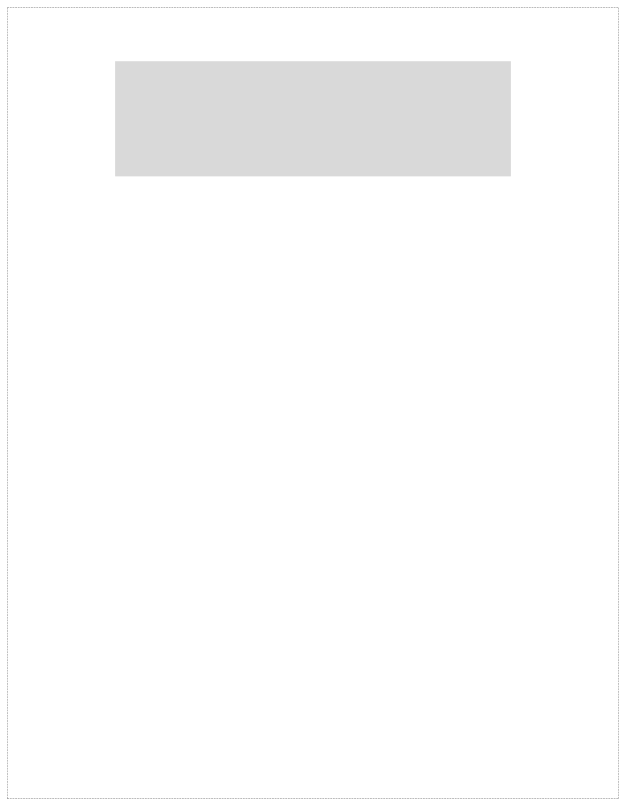

In [1]:
__PRODUCTION__ = 0
__NAME__       = 'motivation'
__WIDTH__      = 5.5  # NeurIPS 2021 text box width
__HEIGHT__     = 1.6

if __PRODUCTION__:
    from mplmagic import pgf
else:
    from mplmagic import svg

from mplmagic.util import SuperFigure, SuperAxes, size_hint
import matplotlib.pyplot as plt

print('This is how much space the figure will take up on letter paper')
size_hint(__WIDTH__, __HEIGHT__, margin_left=0.5 * (8.5 - __WIDTH__));

Low-rank noise

In [2]:
import functools
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim
import networkx as nx
import pickle

from symfac.experimental import RBFExpansionV2

In [22]:
n = 64
r = 1
A = torch.normal(0.0, 1.0, (n, r))
B = torch.normal(0.0, 1.0, (n, r))
target = A @ B.T

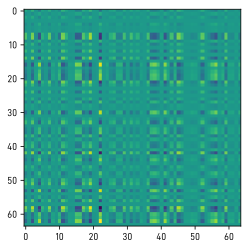

In [23]:
plt.imshow(target)

In [24]:
target.shape

torch.Size([64, 64])

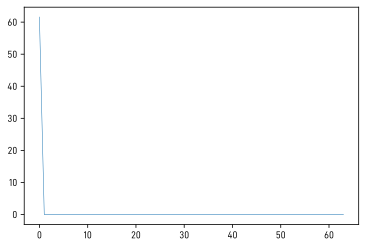

In [25]:
plt.plot(np.linalg.svd(target, compute_uv=False))

100%|██████████| 10000/10000 [00:17<00:00, 559.23it/s]


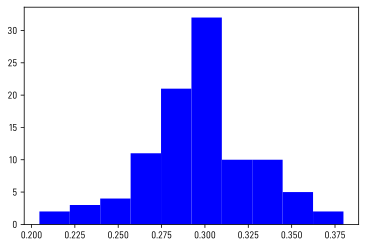

0.2045686


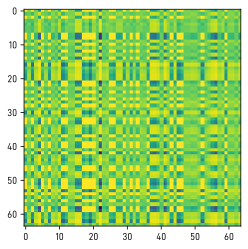

100%|██████████| 10000/10000 [00:17<00:00, 559.68it/s]


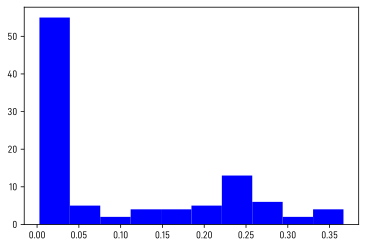

0.0028168


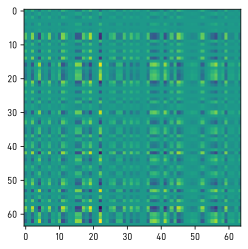

100%|██████████| 10000/10000 [00:16<00:00, 597.37it/s]


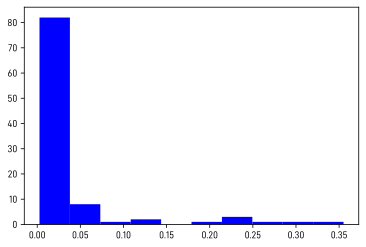

0.0026438


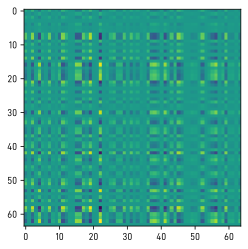

100%|██████████| 10000/10000 [00:19<00:00, 513.60it/s]


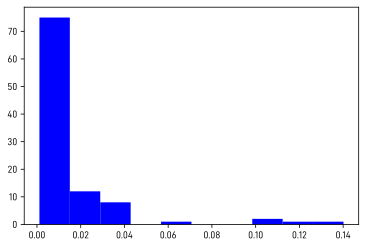

0.00113


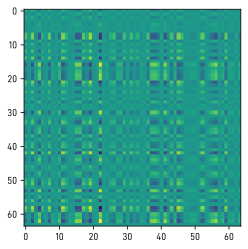

100%|██████████| 10000/10000 [00:22<00:00, 446.87it/s]


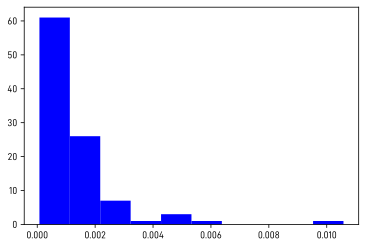

7.53e-05


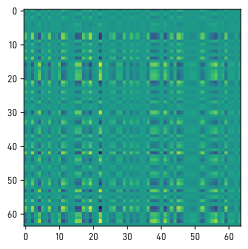

100%|██████████| 10000/10000 [00:31<00:00, 315.74it/s]


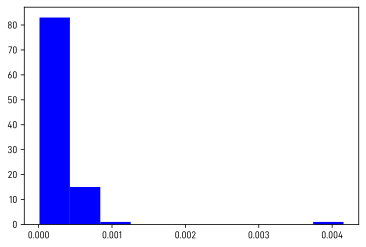

1.19e-05


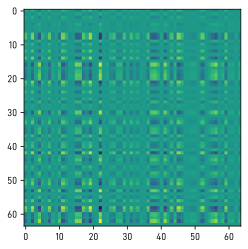

 20%|█▉        | 1993/10000 [00:09<00:38, 207.06it/s]


KeyboardInterrupt: 

In [33]:
n = 64
batch_size = 100
errors = []


# for k in range(1,20):
fibo = [1, 2, 3, 5, 8, 13, 21]
for k in fibo:

    fac = RBFExpansionV2(k=k, batch_size=batch_size, max_steps=10000)
    fac.fit(
        target,
        u0=0.01 * torch.rand([batch_size, len(target), k]),
        v0=0.01 * torch.rand([batch_size, len(target), k]),
        a0=0.01 * torch.randn([batch_size, k], device="cuda"),
        b0=0.01 * torch.randn([batch_size], device="cuda")
    )
    plt.hist(fac.report.loss_best, color='b', label='1')
    plt.show()

    plt.show()
    error = fac.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errors.append(er)
    plt.imshow(fac.optimum(runs=torch.argmin(fac.report.loss_best)))
    plt.show()
    open('gaus_lr_noise_{0}.pickle'.format(k), 'wb').write(pickle.dumps(fac.optimum.x))
print(errors)

In [ ]:
s_vals = []
U0, S0, V0 = np.linalg.svd(target.detach().numpy())
for s in range(1, target.shape[0]+1):
    s_vals.append(round(float(F.mse_loss(torch.tensor((U0[:, :s] * S0[None, :s]) @ V0[:s, :]), target)),7))

In [ ]:
s_vals

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, 65), s_vals, '.-', label='SVD components')
plt.plot(fibo, errors, '.-',label='RBF components')
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('number of components')
plt.legend(loc='upper right', fontsize=12)
#plt.title('Graph kernel 256*256')
plt.show()

In [17]:
# open('n_lr_losses.pickle', 'wb').write(pickle.dumps([errors, s_vals]))

771

In [18]:
# errs, s_vals = pickle.load(open("n_lr_losses.pickle", "rb"))